In [9]:
import pandas as pd
import numpy as np
from MTL_dataset import MTLDataset
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from logs.MTL3.MTL_unetpp import MultiTaskUnetPlusPlus
import torch.nn as nn
import os
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [10]:
validation_data = MTLDataset(
    pd.read_csv("dataset/val.csv"),
    add_gray_channel = True
)

def get_confmat(model_, data=validation_data, title=""):
    class_names = [
        "Background",          # Klasse 0
        "nuclei_tumor",        # Klasse 1
        "nuclei_lymphocyte",   # Klasse 2 (TILs: lymphocytes and plasma cells)
        "Other cells"          # Klasse 3 (histiocytes, stromal cells, etc.)
        ]
    class_names_tissue = [
        "Background",          # Klasse 0
        "tissue_stroma",        # Klasse 1
        "other_tissues",   # Klasse 2 (other)
        "tissue_tumor"          # Klasse 3 
        ]

    num_classes = 4
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    confusion_matrix_nuc = np.zeros((num_classes, num_classes), dtype=np.float64)
    confusion_matrix_tissue = np.zeros((num_classes, num_classes), dtype=np.float64)

    
    validation_loader = DataLoader(data, 8)
    model = MultiTaskUnetPlusPlus(num_classes_task1_tissue= 4,
    num_classes_task2_nuclei = 4,
    in_channels = 4,
    encoder_depth = 4,
    )
    model.load_state_dict(torch.load(os.path.join(path, model_)))
    model.to(device)
    model.eval()

    for (image, t_mask, n_mask) in tqdm(validation_loader):

        image = image.to(device)

        t_mask = t_mask.to(device)
        n_mask = n_mask.to(device)
    
        t_mask = t_mask.long()
        n_mask = n_mask.long()

        t_output, n_output = model(image)
        t_output, n_output = torch.sigmoid(t_output), torch.sigmoid(n_output)
        t_output, n_output = torch.argmax(t_output, dim=1).squeeze(0), torch.argmax(n_output, dim=1).squeeze(0)

        
        t_mask = torch.argmax(t_mask, dim=3)
        n_mask = torch.argmax(n_mask, dim=3)
        
        # Update the confusion matrix
        # Vectorized update to confusion matrix

        t_true_labels = t_mask.view(-1).long()
        t_pred_labels = t_output.view(-1).long()

        n_true_labels = n_mask.view(-1).long()
        n_pred_labels = n_output.view(-1).long()

        t_indices = num_classes * t_true_labels + t_pred_labels
        
        n_indices = num_classes * n_true_labels + n_pred_labels

        

        t_m = torch.bincount(t_indices, minlength=num_classes **
                           2).type(torch.float32)
        t_m = t_m.reshape(num_classes, num_classes)
        confusion_matrix_tissue += t_m.cpu().numpy()

        n_m = torch.bincount(n_indices, minlength=num_classes **
                           2).type(torch.float32)
        n_m = n_m.reshape(num_classes, num_classes)
        confusion_matrix_nuc += n_m.cpu().numpy()


    

    tissue_sum_over_rows = confusion_matrix_tissue.sum(axis=1, keepdims=True)
    tissue_normalized_confusion_matrix = confusion_matrix_tissue / tissue_sum_over_rows
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        tissue_normalized_confusion_matrix,
        annot=True,
        cmap="viridis",
        vmin=0,
        vmax=1,
        xticklabels=class_names_tissue,
        yticklabels=class_names_tissue,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("MTL-Normalized Confusion Matrix-Tissue" + title)
    plt.savefig(fr"{path}/tissue_normalized_confusion_matrix.png", dpi=150, bbox_inches="tight")
    plt.show()


    nuc_sum_over_rows = confusion_matrix_nuc.sum(axis=1, keepdims=True)
    nuc_normalized_confusion_matrix = confusion_matrix_nuc / nuc_sum_over_rows
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        nuc_normalized_confusion_matrix,
        annot=True,
        cmap="viridis",
        vmin=0,
        vmax=1,
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("MTL-Normalized Confusion Matrix-Nuclei" + title)

    plt.savefig(fr"{path}/nuc_normalized_confusion_matrix.png", dpi=150, bbox_inches="tight")
    plt.show()


    nuc_f1_scores = []
    for i in range(num_classes):
        tp = confusion_matrix_nuc[i, i]
        fp = confusion_matrix_nuc[:, i].sum() - tp
        fn = confusion_matrix_nuc[i, :].sum() - tp
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        nuc_f1_scores.append(f1)

    nuc_mean_f1 = np.mean(nuc_f1_scores[1:])

    t_f1_scores = []
    for i in range(num_classes):
        tp = confusion_matrix_tissue[i, i]
        fp = confusion_matrix_tissue[:, i].sum() - tp
        fn = confusion_matrix_tissue[i, :].sum() - tp
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        t_f1_scores.append(f1)

    t_mean_f1 = np.mean(t_f1_scores[1:])
    
    # Save F1 scores and mean F1 to a text file
    f1_file_path = os.path.join(path, "f1_scores.txt")
    with open(f1_file_path, "w") as f:
        f.write("F1 Scores for each class:\n")
        for class_name, f1_score in zip(class_names, nuc_f1_scores):
            f.write(f"{class_name}: {f1_score:.4f}\n")
        f.write(f"\nMean F1 Score: {nuc_mean_f1:.4f}\n")

        for class_name, f1_score in zip(class_names_tissue, t_f1_scores):
            f.write(f"{class_name}: {f1_score:.4f}\n")
        f.write(f"\nMean F1 Score: {t_mean_f1:.4f}\n")
        mf = (t_mean_f1+nuc_mean_f1)/2
        f.write(f"\nMean F1 Score (2 tasks): {mf:.4f}\n")


    
        

    print("F1 Scores for each class:", dict(zip(class_names, nuc_f1_scores)))
    print("Mean F1 Score:", nuc_mean_f1)
    
    print("F1 Scores for each class:", dict(zip(class_names_tissue, t_f1_scores)))
    print("Mean F1 Score:", t_mean_f1)

    return confusion_matrix_tissue, confusion_matrix_nuc

100%|█████████████████████████████████████████| 132/132 [01:45<00:00,  1.25it/s]


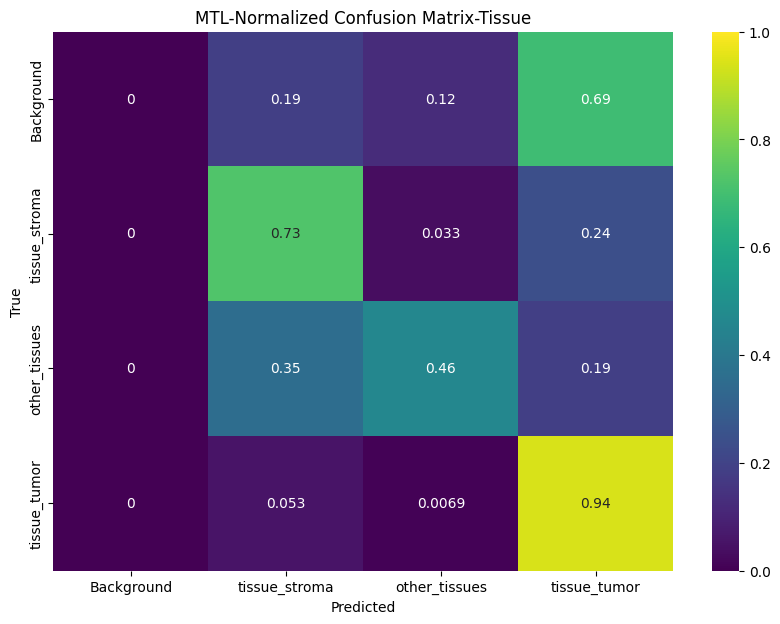

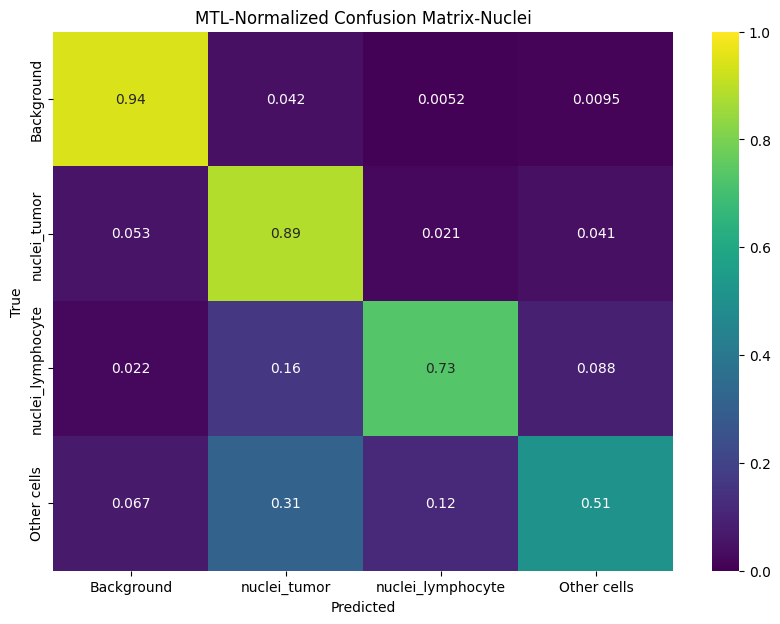

F1 Scores for each class: {'Background': 0.9634583029652077, 'nuclei_tumor': 0.8260021561498273, 'nuclei_lymphocyte': 0.6773053034945998, 'Other cells': 0.4763249317214259}
Mean F1 Score: 0.6598774637886177
F1 Scores for each class: {'Background': 0, 'tissue_stroma': 0.7327953909490681, 'other_tissues': 0.5031725587458015, 'tissue_tumor': 0.9327995243550979}
Mean F1 Score: 0.7229224913499891


(array([[0.0000000e+00, 3.1941000e+04, 2.1066000e+04, 1.1855100e+05],
        [0.0000000e+00, 1.0247384e+07, 4.6588300e+05, 3.4147470e+06],
        [0.0000000e+00, 7.9043400e+05, 1.0399500e+06, 4.1716600e+05],
        [0.0000000e+00, 2.7701540e+06, 3.5912300e+05, 4.9136401e+07]]),
 array([[5.0232789e+07, 2.2342340e+06, 2.7857700e+05, 5.0560000e+05],
        [6.2948300e+05, 1.0590941e+07, 2.4563900e+05, 4.9424400e+05],
        [3.7544000e+04, 2.7361300e+05, 1.2648260e+06, 1.5301500e+05],
        [1.2498400e+05, 5.8476300e+05, 2.1683700e+05, 9.4571100e+05]]))

In [11]:
path = r"logs/MTL3"
weight_path = r"best_f1.pt"
get_confmat(weight_path)

In [4]:
def visualize_mask_difference(true_mask, pred_mask):
    """
    Visualisiert die Unterschiede zwischen der tatsächlichen und der vorhergesagten Maske in RGB:
    - Weiß: Korrekte Übereinstimmung
    - Rot: Falsch negative
    - Blau: Falsch positive
    
    Parameters:
    - true_mask_rgb: Numpy-Array der tatsächlichen Maske im RGB-Format
    - pred_mask_rgb: Numpy-Array der vorhergesagten Maske im RGB-Format
    """
    
    # RGB-Differenzmaske erstellen
    diff_mask = np.zeros((true_mask.shape[0], true_mask.shape[1], 3), dtype=np.uint8)

    # Bedingte Zuweisung mit Prüfung, ob Bedingung erfüllt ist
    if np.any((true_mask == 1) & (pred_mask == 0)):
        diff_mask[(true_mask == 1) & (pred_mask == 0)] = [255, 0, 0]  # Rot für falsch negative

    if np.any((true_mask == 0) & (pred_mask == 1)):
        diff_mask[(true_mask == 0) & (pred_mask == 1)] = [0, 0, 255]  # Blau für falsch positive

    # Übereinstimmende Pixel: Weiß anzeigen
    diff_mask[true_mask == pred_mask] = [255, 255, 255]  # Weiß für korrekt
    # Übereinstimmung beim Hintergrund ebenfalls weiß anzeigen
    diff_mask[(true_mask == 0) & (pred_mask == 0)] = [255, 255, 255]  # Weiß für Hintergrund-Übereinstimmung
    # Visualisierung anzeigen
    plt.figure(figsize=(5, 5))
    plt.title("Differenz zwischen True Mask und Pred Mask (RGB)")
    plt.imshow(diff_mask)
    plt.axis('off')  # Achsen ausblenden für bessere Darstellung

    # Legende erstellen
    correct_patch = mpatches.Patch(color='white', label='Korrekte Übereinstimmung')
    false_negative_patch = mpatches.Patch(color='red', label='Falsch negativ (nicht erkannt)')
    false_positive_patch = mpatches.Patch(color='blue', label='Falsch positiv (erfunden)')
    
    # Legende zur Grafik hinzufügen
    plt.legend(handles=[correct_patch, false_negative_patch, false_positive_patch],
               loc='upper right', bbox_to_anchor=(0.0, 0.0))
    
    plt.show()

    return diff_mask



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


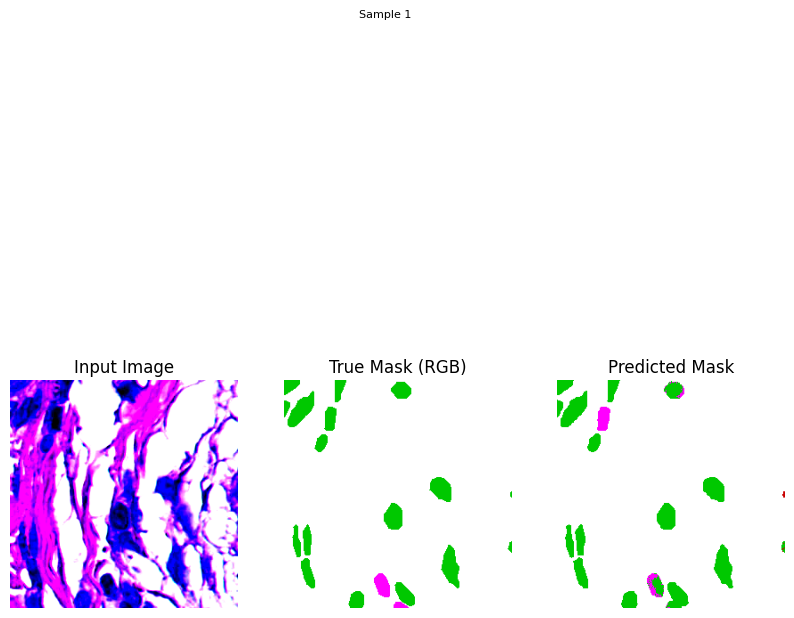

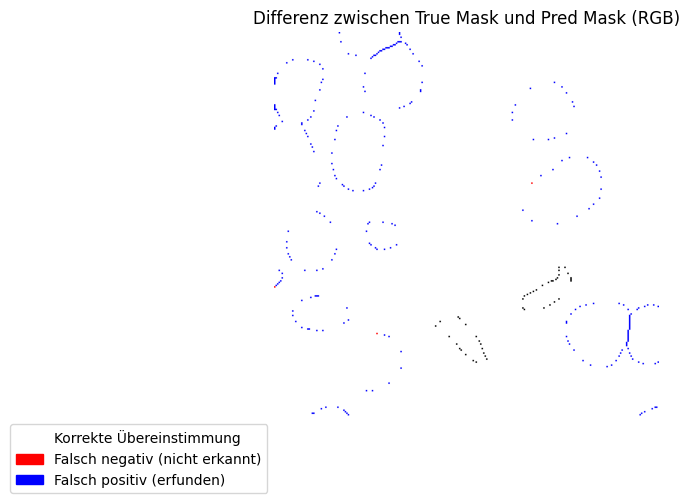

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


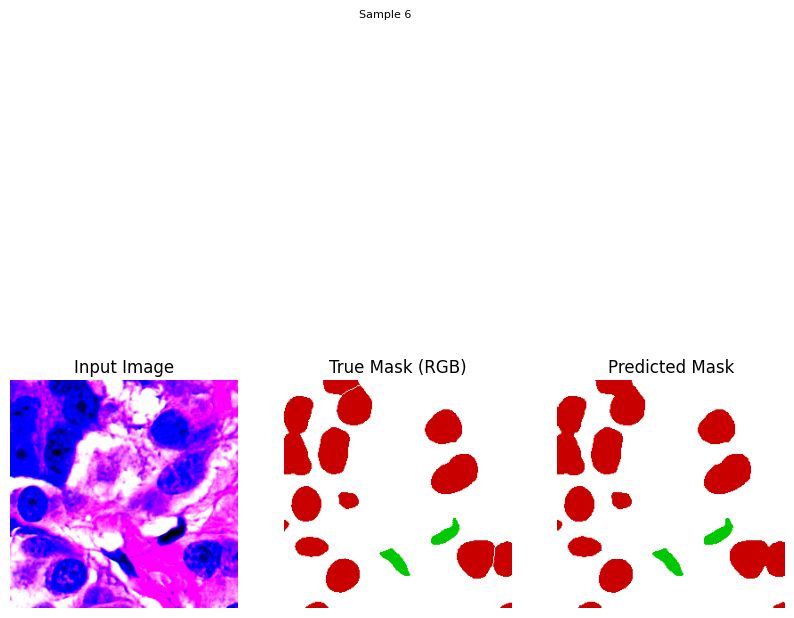

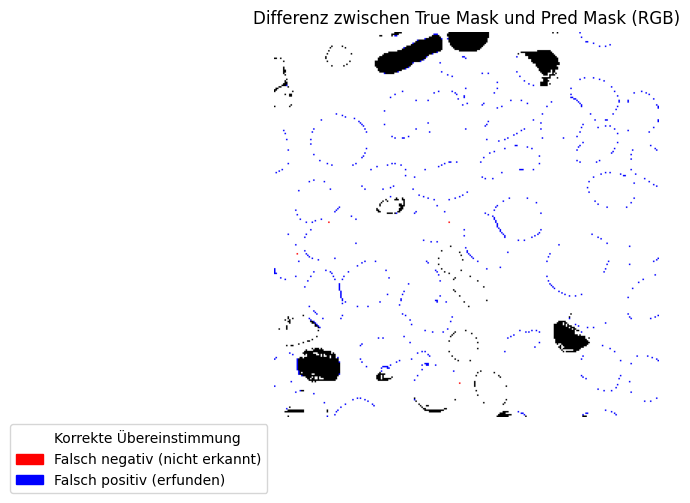

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


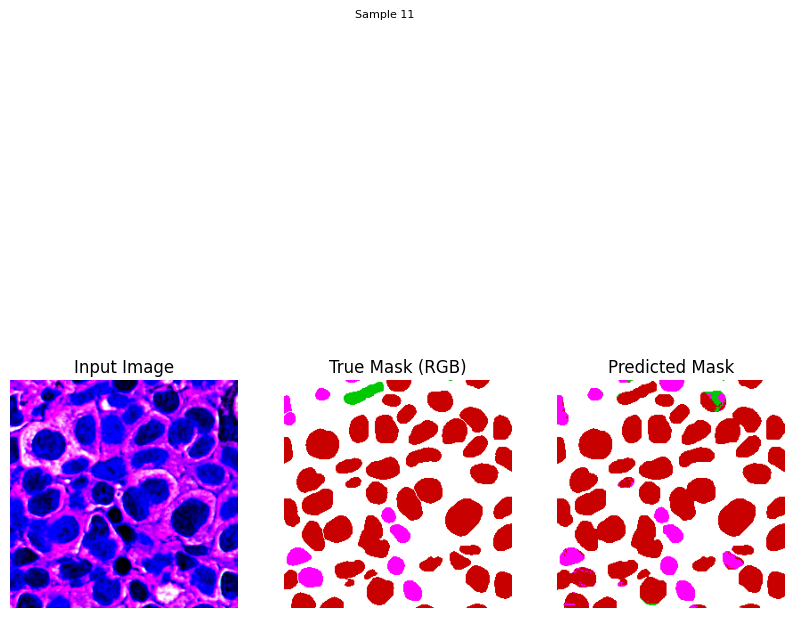

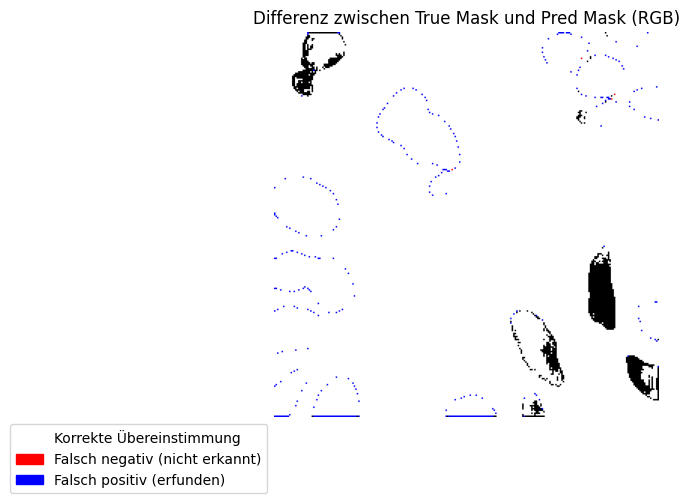

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


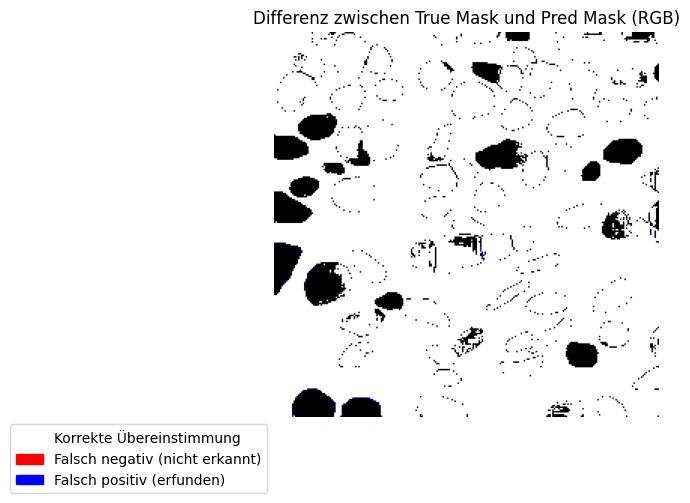

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


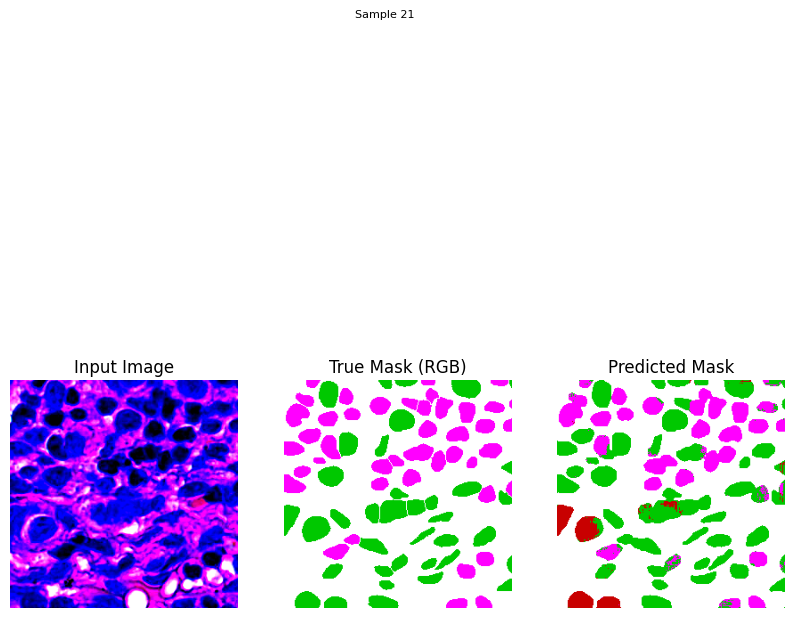

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import random


num_classes = 4

class_colors = [
    (255, 255, 255),  # Background
    (200, 0, 0),      # nuclei_tumor
    (255, 0, 255),    # nuclei_lymphocyte
    (0, 200, 0)   # Other cells
]

def apply_color_mapping(mask, class_colors):
    """Map class values in the mask to RGB colors."""
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for k, color in enumerate(class_colors):
        mask_rgb[mask == k] = color
    return mask_rgb

def visualize_predictions(model_path, data_loader, num_samples=5):
    # Model laden und in Evaluierungsmodus setzen
    model = HalfDualDecUNetPlusPlus()
    model.load_state_dict(torch.load(model_path))
    model = nn.Sequential(model, nn.Sigmoid())
    model.cuda()
    model.eval()
    
    # Schleife durch den Dataloader
    for i, (images, masks) in enumerate(data_loader):
        if i >= num_samples:
            break  # Stop after showing the desired number of samples
        
        # Eingabebilder auf die GPU übertragen
        images = images.cuda()
        
        # Vorhersagen erhalten
        with torch.no_grad():
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)  # Klassenwerte ausgeben

        # Visualization of each image, mask, and prediction
        for j in range(images.size(0)):
            # Bild, Vorhersage und echte Maske extrahieren
            img = images[j].cpu().numpy().transpose(1, 2, 0)
            
            # true_mask konvertieren von One-Hot-Encoding zu Klassenindizes
            true_mask = masks[j].cpu().numpy()
            true_mask = np.argmax(true_mask, axis=-1)  # One-Hot-Encoded Mask zu Klasse

            # Vorhersagemaske in numpy umwandeln
            pred_mask = predictions[j].cpu().numpy()

            # Map class values to RGB colors for true and predicted masks
            true_mask_rgb = apply_color_mapping(true_mask, class_colors)
            pred_mask_rgb = apply_color_mapping(pred_mask, class_colors)
            visualize_mask_difference(true_mask, pred_mask)
            # Subplot erstellen
            fig, axes = plt.subplots(1, 3, figsize=(10, 10))
            fig.suptitle(f"Sample {i*num_samples + j + 1}", fontsize=8)
            # Originales Bild anzeigen
            axes[0].imshow(np.clip(img[..., :3], 0, 255))
            axes[0].set_title("Input Image")
            axes[0].axis("off")

            # Wahre Maske (RGB) anzeigen
            axes[1].imshow(true_mask_rgb)
            axes[1].set_title("True Mask (RGB)")
            axes[1].axis("off")

            # Vorhersagemaske anzeigen
            axes[2].imshow(pred_mask_rgb)
            axes[2].set_title("Predicted Mask")
            axes[2].axis("off")
           # plt.savefig(f"sample_{i*num_samples + j + 1}_prediction.png", dpi=150, bbox_inches="tight")
            plt.show()


# Datenloader für das Validierungsset erstellen
validation_data = NucleiSegmentationDataset(pd.read_csv("dataset/val.csv"), add_gray_channel=True ,ttrain=False)
validation_loader = DataLoader(validation_data, batch_size=1, shuffle=True)

path = r"logs/Nuclei_seg27"
weight_path = r"best_f1.pt"
visualize_predictions(os.path.join(path, weight_path), validation_loader)

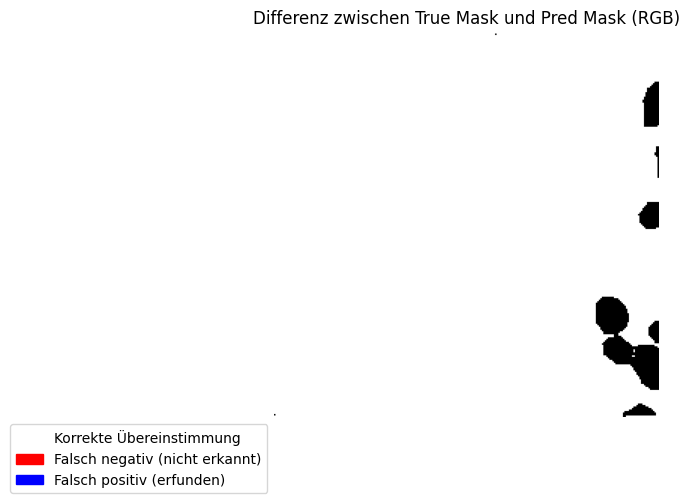

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


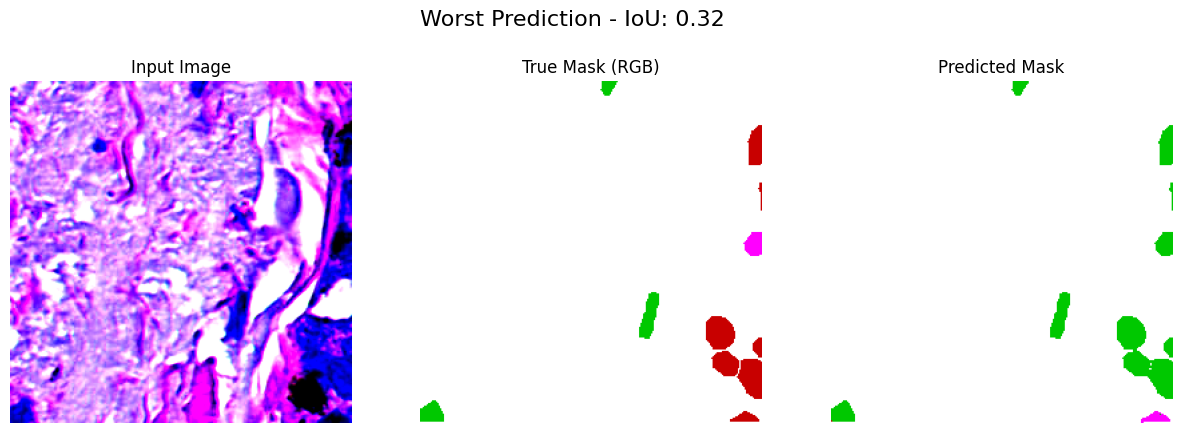

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


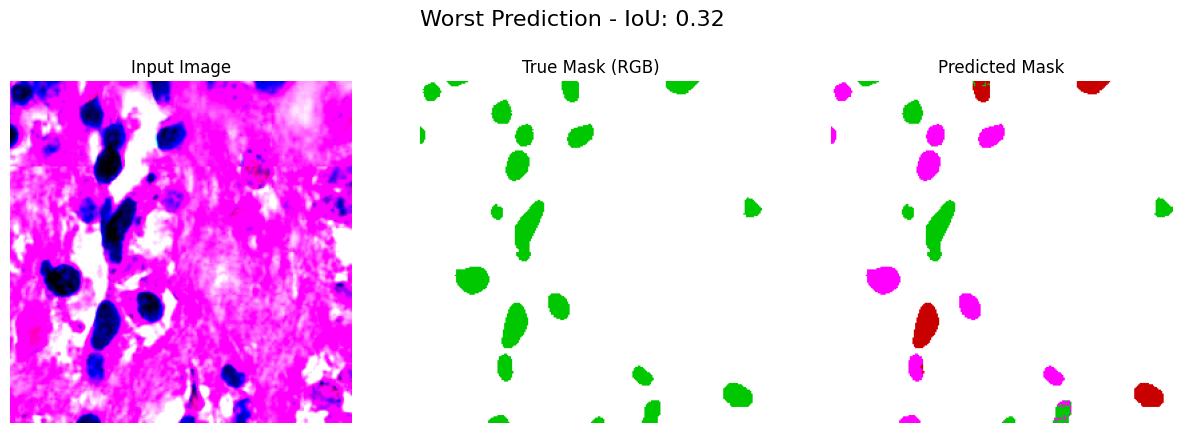

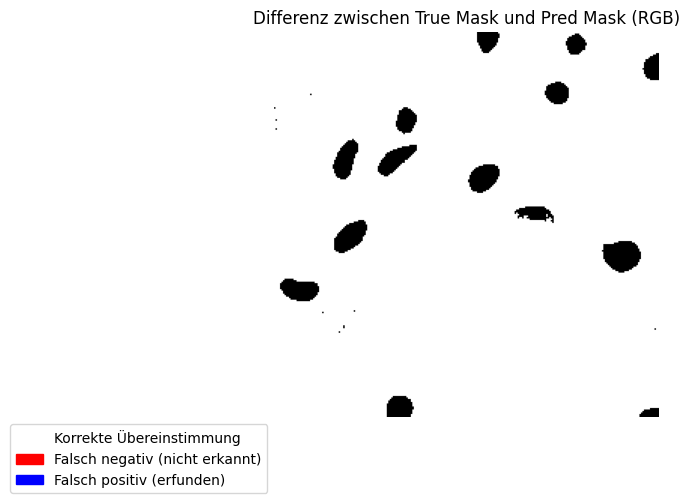

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


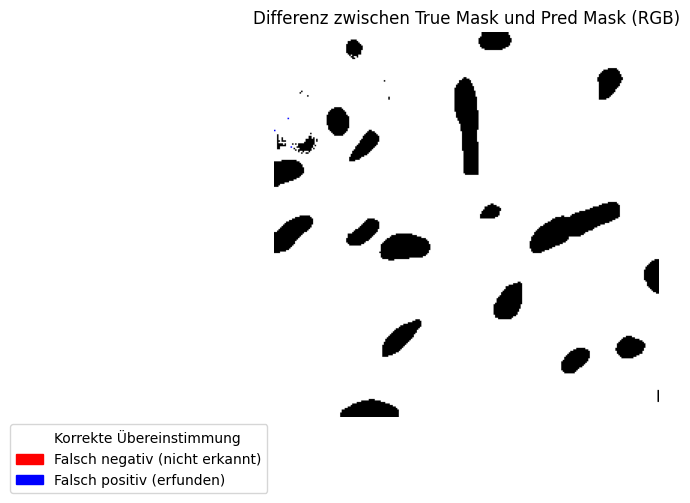

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


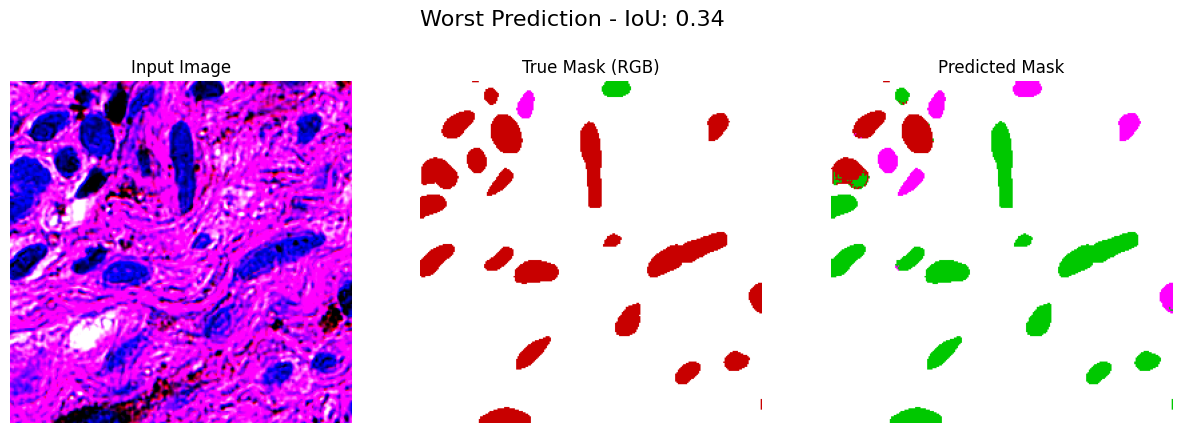

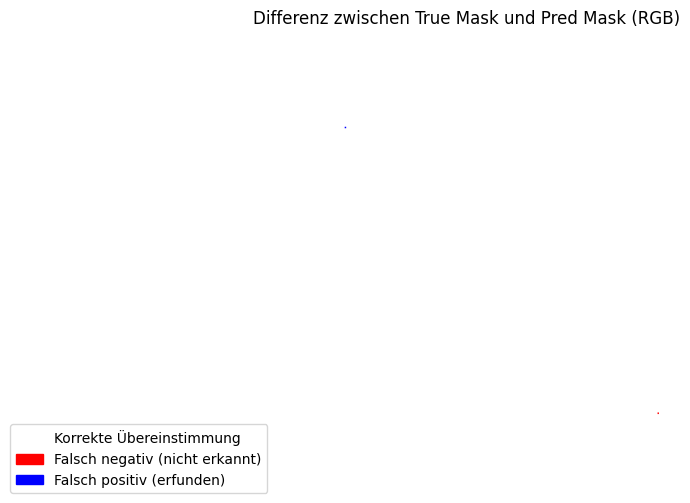

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


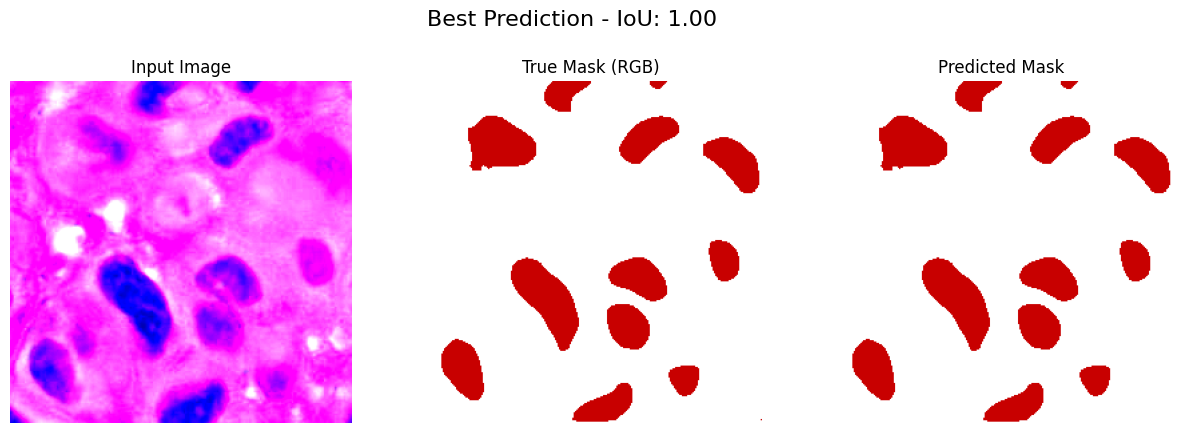

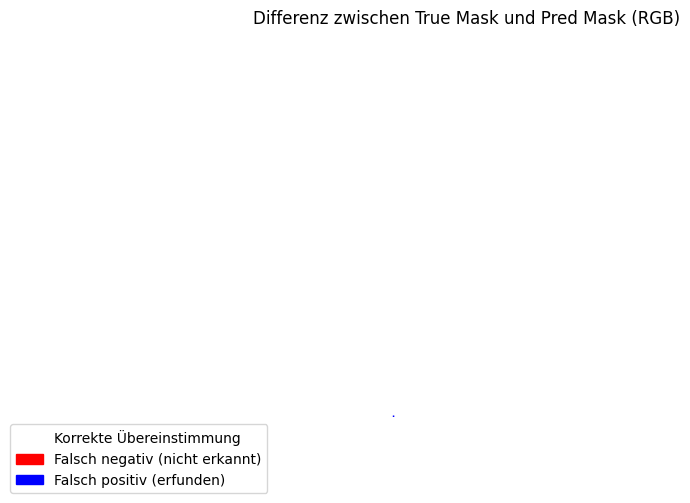

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


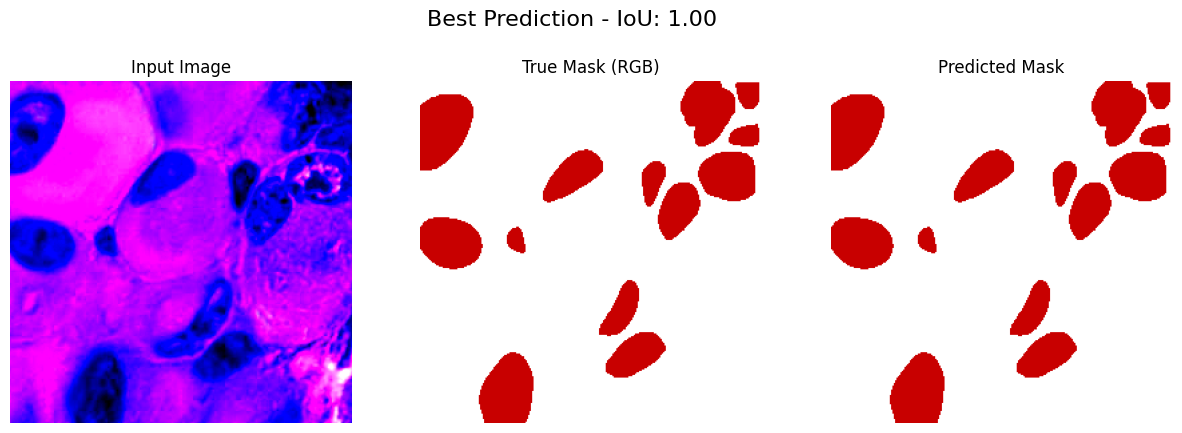

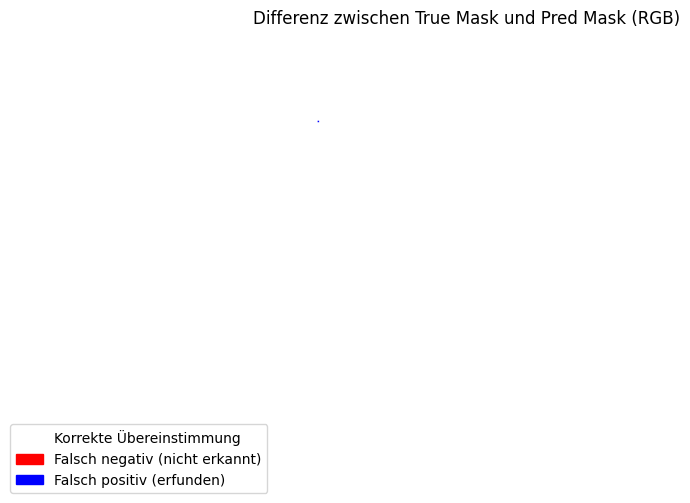

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


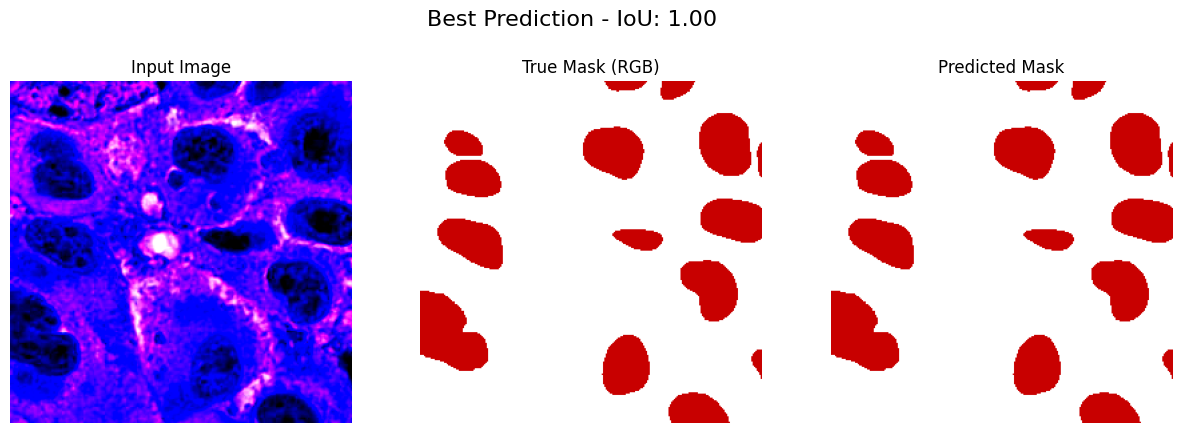

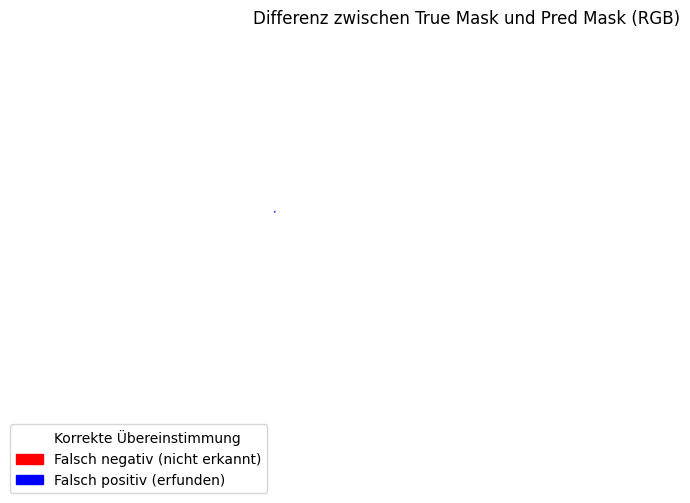

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


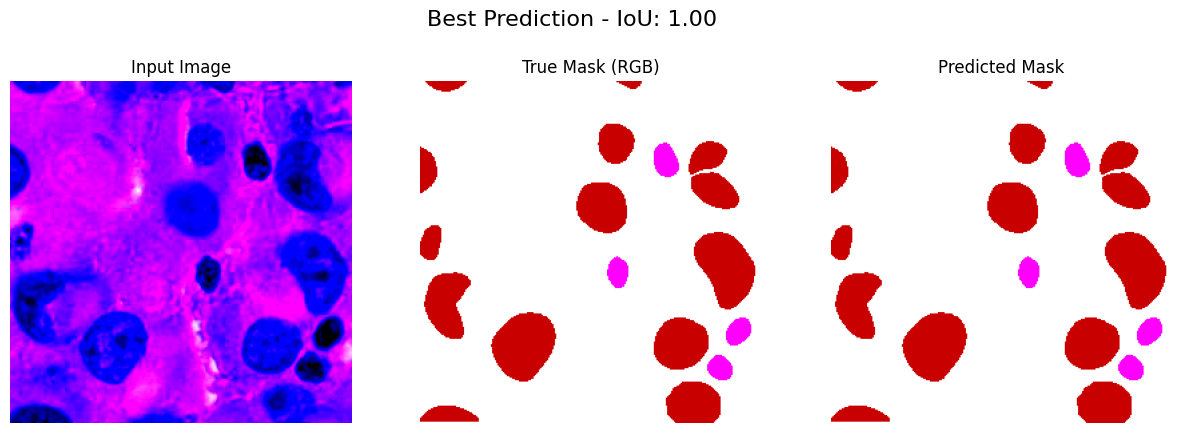

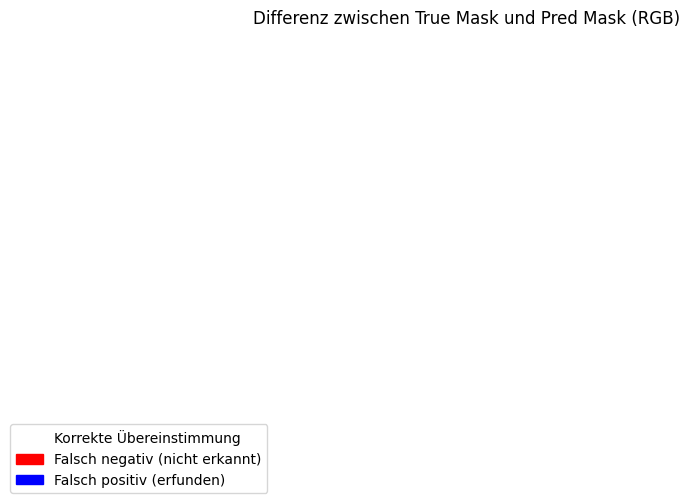

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


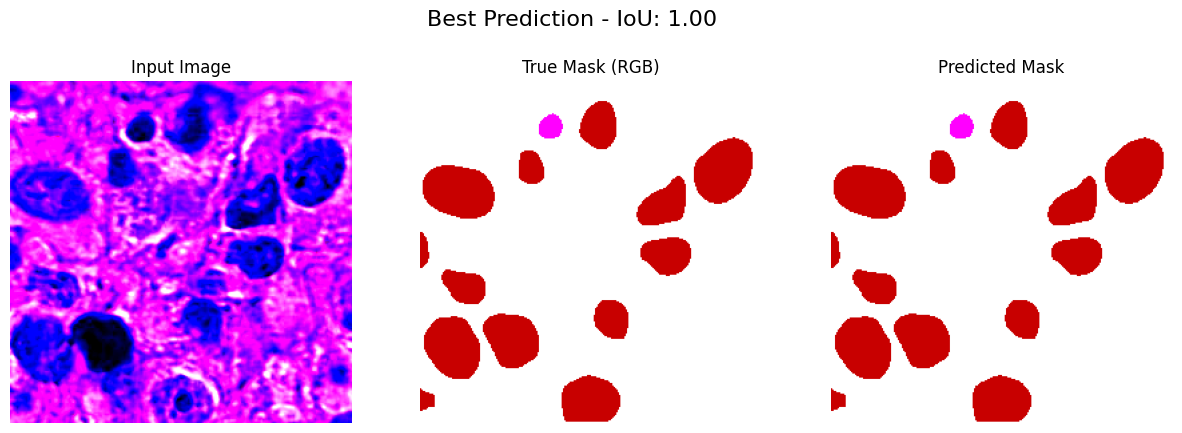

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import os

# Define class colors for visualization
class_colors = [
    (255, 255, 255),  # Background
    (200, 0, 0),      # nuclei_tumor
    (255, 0, 255),    # nuclei_lymphocyte
    (0, 200, 0)   # Other cells
]

def apply_color_mapping(mask, class_colors):
    """Map class values in the mask to RGB colors."""
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for k, color in enumerate(class_colors):
        mask_rgb[mask == k] = color
    return mask_rgb

def calculate_iou(pred, true):
    """Calculate Intersection over Union (IoU) for each class and return the mean IoU."""
    iou_scores = []
    for class_idx in range(len(class_colors)):
        intersection = np.logical_and(pred == class_idx, true == class_idx).sum()
        union = np.logical_or(pred == class_idx, true == class_idx).sum()
        if union == 0:
            iou_scores.append(float('nan'))  # Ignore classes not present in the sample
        else:
            iou_scores.append(intersection / union)
    return np.nanmean(iou_scores)  # Compute mean IoU, ignoring NaNs

def visualize_best_worst_predictions(model_path, data_loader, num_samples=5):
    # Model laden und in Evaluierungsmodus setzen
    model = HalfDualDecUNetPlusPlus()
    model.load_state_dict(torch.load(model_path))
    model = nn.Sequential(model, nn.Sigmoid())
    model.cuda()
    model.eval()
    
    predictions_data = []

    # Schleife durch den Dataloader
    for images, masks in data_loader:
        # Eingabebilder auf die GPU übertragen
        images = images.cuda()
        
        # Vorhersagen erhalten
        with torch.no_grad():
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)  # Klassenwerte ausgeben

        for j in range(images.size(0)):
            # Bild, Vorhersage und echte Maske extrahieren
            img = images[j].cpu().numpy().transpose(1, 2, 0)
            true_mask = masks[j].cpu().numpy()
            true_mask = np.argmax(true_mask, axis=-1)  # One-Hot-Encoded Mask zu Klasse
            pred_mask = predictions[j].cpu().numpy()

            # IoU berechnen
            iou_score = calculate_iou(pred_mask, true_mask)
            predictions_data.append((iou_score, img, true_mask, pred_mask))

    # Sortiere die Vorhersagen nach IoU-Score
    predictions_data.sort(key=lambda x: x[0])  # Sortiert von schlechtester zu bester Vorhersage

    # Die schlechtesten und besten Ergebnisse visualisieren
    for idx, (iou, img, true_mask, pred_mask) in enumerate(predictions_data[:num_samples] + predictions_data[-num_samples:]):
        true_mask_rgb = apply_color_mapping(true_mask, class_colors)
        pred_mask_rgb = apply_color_mapping(pred_mask, class_colors)
        
        dff_mask = visualize_mask_difference(true_mask, pred_mask)
        diff_mask_image = Image.fromarray(dff_mask)  # Numpy-Array in ein Bild umwandeln
        diff_mask_image.save((fr"{path}/{'worst' if idx < num_samples else 'best'}_sample_{idx + 1}_iou_{iou:.2f}_diff_mask.png")) 
        # Subplot erstellen
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f"{'Worst' if idx < num_samples else 'Best'} Prediction - IoU: {iou:.2f}", fontsize=16)

        # Originales Bild anzeigen
        axes[0].imshow(img[..., :3])  # Zeigt nur die ersten drei Kanäle (z. B. RGB)
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        # Wahre Maske (RGB) anzeigen
        axes[1].imshow(true_mask_rgb)
        axes[1].set_title("True Mask (RGB)")
        axes[1].axis("off")

        # Vorhersagemaske anzeigen
        axes[2].imshow(pred_mask_rgb)
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

        plt.savefig(fr"{path}/{'worst' if idx < num_samples else 'best'}_sample_{idx + 1}_iou_{iou:.2f}.png", dpi=150, bbox_inches="tight")
        plt.show()

# Datenloader für das Validierungsset erstellen
validation_data = NucleiSegmentationDataset(pd.read_csv("dataset/val.csv"),add_gray_channel = True, ttrain=False)
validation_loader = DataLoader(validation_data, batch_size=1, shuffle=True)

path = r"logs/Nuclei_seg29"
# Modellpfad und Datenloader an die Funktion übergeben
model_path = os.path.join(path, "best_f1.pt")
visualize_best_worst_predictions(model_path, validation_loader)

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import os

# Define class colors for visualization
class_colors = [
    (255, 255, 255),  # Background
    (200, 0, 0),      # nuclei_tumor
    (255, 0, 255),    # nuclei_lymphocyte
    (0, 200, 0)   # Other cells
]

def apply_color_mapping(mask, class_colors):
    """Map class values in the mask to RGB colors."""
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for k, color in enumerate(class_colors):
        mask_rgb[mask == k] = color
    return mask_rgb

def calculate_iou(pred, true):
    """Calculate Intersection over Union (IoU) for each class and return the mean IoU."""
    iou_scores = []
    for class_idx in range(len(class_colors)):
        intersection = np.logical_and(pred == class_idx, true == class_idx).sum()
        union = np.logical_or(pred == class_idx, true == class_idx).sum()
        if union == 0:
            iou_scores.append(float('nan'))  # Ignore classes not present in the sample
        else:
            iou_scores.append(intersection / union)
    return np.nanmean(iou_scores)  # Compute mean IoU, ignoring NaNs

def visualize_best_worst_predictions(model_path, data_loader, num_samples=5):
    # Model laden und in Evaluierungsmodus setzen
    model = HalfDualDecUNetPlusPlus(in_channel=3)
    model.load_state_dict(torch.load(model_path))
    model = nn.Sequential(model, nn.Sigmoid())
    model.cuda()
    model.eval()
    
    predictions_data = []

    # Schleife durch den Dataloader
    for images, masks in data_loader:
        # Eingabebilder auf die GPU übertragen
        images = images.cuda()
        
        # Vorhersagen erhalten
        with torch.no_grad():
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)  # Klassenwerte ausgeben

        for j in range(images.size(0)):
            # Bild, Vorhersage und echte Maske extrahieren
            img = images[j].cpu().numpy().transpose(1, 2, 0)
            true_mask = masks[j].cpu().numpy()
            true_mask = np.argmax(true_mask, axis=-1)  # One-Hot-Encoded Mask zu Klasse
            pred_mask = predictions[j].cpu().numpy()

            # IoU berechnen
            iou_score = calculate_iou(pred_mask, true_mask)
            predictions_data.append((iou_score, img, true_mask, pred_mask))

    # Sortiere die Vorhersagen nach IoU-Score
    predictions_data.sort(key=lambda x: x[0])  # Sortiert von schlechtester zu bester Vorhersage

    # Die schlechtesten und besten Ergebnisse visualisieren
    for idx, (iou, img, true_mask, pred_mask) in enumerate(predictions_data[:num_samples] + predictions_data[-num_samples:]):
        true_mask_rgb = apply_color_mapping(true_mask, class_colors)
        pred_mask_rgb = apply_color_mapping(pred_mask, class_colors)
        visualize_mask_difference(true_mask, pred_mask)

        # Subplot erstellen
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f"{'Worst' if idx < num_samples else 'Best'} Prediction - IoU: {iou:.2f}", fontsize=16)

        # Originales Bild anzeigen
        axes[0].imshow(img)
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        # Wahre Maske (RGB) anzeigen
        axes[1].imshow(true_mask_rgb)
        axes[1].set_title("True Mask (RGB)")
        axes[1].axis("off")

        # Vorhersagemaske anzeigen
        axes[2].imshow(pred_mask_rgb)
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

        plt.savefig(fr"{path}/{'worst' if idx < num_samples else 'best'}_sample_{idx + 1}_iou_{iou:.2f}.png", dpi=150, bbox_inches="tight")
        plt.show()

# Datenloader für das Validierungsset erstellen
validation_data = NucleiSegmentationDataset(pd.read_csv("dataset/val.csv"),add_gray_channel = False, ttrain=False, norm= False)
validation_loader = DataLoader(validation_data, batch_size=1, shuffle=True)

path = r"logs/M_Baseline"
# Modellpfad und Datenloader an die Funktion übergeben
model_path = os.path.join(path, "best_f1.pt")
visualize_best_worst_predictions(model_path, validation_loader)

RuntimeError: Error(s) in loading state_dict for HalfDualDecUNetPlusPlus:
	Missing key(s) in state_dict: "decoder_tissue1.blocks.x_0_0.attention1.attention.cSE.1.weight", "decoder_tissue1.blocks.x_0_0.attention1.attention.cSE.1.bias", "decoder_tissue1.blocks.x_0_0.attention1.attention.cSE.3.weight", "decoder_tissue1.blocks.x_0_0.attention1.attention.cSE.3.bias", "decoder_tissue1.blocks.x_0_0.attention1.attention.sSE.0.weight", "decoder_tissue1.blocks.x_0_0.attention1.attention.sSE.0.bias", "decoder_tissue1.blocks.x_0_0.attention2.attention.cSE.1.weight", "decoder_tissue1.blocks.x_0_0.attention2.attention.cSE.1.bias", "decoder_tissue1.blocks.x_0_0.attention2.attention.cSE.3.weight", "decoder_tissue1.blocks.x_0_0.attention2.attention.cSE.3.bias", "decoder_tissue1.blocks.x_0_0.attention2.attention.sSE.0.weight", "decoder_tissue1.blocks.x_0_0.attention2.attention.sSE.0.bias", "decoder_tissue1.blocks.x_0_1.attention1.attention.cSE.1.weight", "decoder_tissue1.blocks.x_0_1.attention1.attention.cSE.1.bias", "decoder_tissue1.blocks.x_0_1.attention1.attention.cSE.3.weight", "decoder_tissue1.blocks.x_0_1.attention1.attention.cSE.3.bias", "decoder_tissue1.blocks.x_0_1.attention1.attention.sSE.0.weight", "decoder_tissue1.blocks.x_0_1.attention1.attention.sSE.0.bias", "decoder_tissue1.blocks.x_0_1.attention2.attention.cSE.1.weight", "decoder_tissue1.blocks.x_0_1.attention2.attention.cSE.1.bias", "decoder_tissue1.blocks.x_0_1.attention2.attention.cSE.3.weight", "decoder_tissue1.blocks.x_0_1.attention2.attention.cSE.3.bias", "decoder_tissue1.blocks.x_0_1.attention2.attention.sSE.0.weight", "decoder_tissue1.blocks.x_0_1.attention2.attention.sSE.0.bias", "decoder_tissue1.blocks.x_1_1.attention1.attention.cSE.1.weight", "decoder_tissue1.blocks.x_1_1.attention1.attention.cSE.1.bias", "decoder_tissue1.blocks.x_1_1.attention1.attention.cSE.3.weight", "decoder_tissue1.blocks.x_1_1.attention1.attention.cSE.3.bias", "decoder_tissue1.blocks.x_1_1.attention1.attention.sSE.0.weight", "decoder_tissue1.blocks.x_1_1.attention1.attention.sSE.0.bias", "decoder_tissue1.blocks.x_1_1.attention2.attention.cSE.1.weight", "decoder_tissue1.blocks.x_1_1.attention2.attention.cSE.1.bias", "decoder_tissue1.blocks.x_1_1.attention2.attention.cSE.3.weight", "decoder_tissue1.blocks.x_1_1.attention2.attention.cSE.3.bias", "decoder_tissue1.blocks.x_1_1.attention2.attention.sSE.0.weight", "decoder_tissue1.blocks.x_1_1.attention2.attention.sSE.0.bias", "decoder_tissue1.blocks.x_0_2.attention1.attention.cSE.1.weight", "decoder_tissue1.blocks.x_0_2.attention1.attention.cSE.1.bias", "decoder_tissue1.blocks.x_0_2.attention1.attention.cSE.3.weight", "decoder_tissue1.blocks.x_0_2.attention1.attention.cSE.3.bias", "decoder_tissue1.blocks.x_0_2.attention1.attention.sSE.0.weight", "decoder_tissue1.blocks.x_0_2.attention1.attention.sSE.0.bias", "decoder_tissue1.blocks.x_0_2.attention2.attention.cSE.1.weight", "decoder_tissue1.blocks.x_0_2.attention2.attention.cSE.1.bias", "decoder_tissue1.blocks.x_0_2.attention2.attention.cSE.3.weight", "decoder_tissue1.blocks.x_0_2.attention2.attention.cSE.3.bias", "decoder_tissue1.blocks.x_0_2.attention2.attention.sSE.0.weight", "decoder_tissue1.blocks.x_0_2.attention2.attention.sSE.0.bias". 

In [17]:
import torch
from torch.utils.data import DataLoader
import os
import segmentation_models_pytorch as smp

# Deine F1-Score-Funktion
def f1_score(tp, fp, fn):
    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    return 2 * (precision * recall) / (precision + recall + epsilon)

# Funktion zum Berechnen von F1-Score für das gesamte Validierungsset
def calculate_f1_score_with_smp(model_path, data_loader, num_classes):
    # Model laden und in Evaluierungsmodus setzen
    model = HalfDualDecUNetPlusPlus()
    model.load_state_dict(torch.load(model_path))
    model = nn.Sequential(model, nn.Sigmoid())
    model.cuda()
    model.eval()
    
    # Variablen für TP, FP, FN, TN initialisieren
    val_pos_neg = torch.zeros(4, num_classes)
    
    # Schleife durch den Dataloader
    for images, masks in data_loader:
        # Eingabebilder und wahre Masken auf die GPU übertragen
        images = images.cuda()
        masks = torch.argmax(masks, dim=3).cuda()  # Wahre Masken in Klassenindizes umwandeln

        # Vorhersagen erhalten
        with torch.no_grad():
            output_pb = model(images)
            predictions = torch.argmax(output_pb, dim=1)  # Klassenwerte für Vorhersage
        
        # Berechne TP, FP, FN, TN
        tp, fp, fn, tn = smp.metrics.get_stats(
            predictions, masks, mode='multiclass', num_classes=num_classes
        )
        
        # Akkumuliere die Statistiken für das gesamte Validierungsset
        val_pos_neg += torch.stack([torch.sum(tp, 0), torch.sum(fp, 0), torch.sum(fn, 0), torch.sum(tn, 0)])

    # Berechne den F1-Score für jede Klasse
    tp, fp, fn, _ = val_pos_neg
    f1_scores = f1_score(tp, fp, fn)
    
    # Berechne den mittleren F1-Score, indem wir den Durchschnitt der F1-Scores über alle Klassen nehmen
    mean_f1_score = f1_scores.mean()

    # Ausgabe der F1-Scores für jede Klasse und des Durchschnitts
    for i, score in enumerate(f1_scores):
        print(f"F1 Score for class {i}: {score:.4f}")
    print(f"Mean F1 Score: {mean_f1_score:.4f}")
    
    return f1_scores, mean_f1_score

# Datenloader für das Validierungsset erstellen
validation_data = NucleiSegmentationDataset(pd.read_csv("dataset/val.csv"), add_gray_channel = True, ttrain=False)
validation_loader = DataLoader(validation_data, batch_size=1, shuffle=False)

# Modellpfad und Datenloader an die Funktion übergeben
model_path = os.path.join("logs/Nuclei_seg6", "best_f1.pt")
f1_scores, mean_f1_score = calculate_f1_score_with_smp(model_path, validation_loader, num_classes=4)

F1 Score for class 0: 0.9661
F1 Score for class 1: 0.8097
F1 Score for class 2: 0.6648
F1 Score for class 3: 0.4079
Mean F1 Score: 0.7121


In [7]:
import torch
from torch.utils.data import DataLoader
import os
import segmentation_models_pytorch as smp

# Deine F1-Score-Funktion
def f1_score(tp, fp, fn):
    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    return 2 * (precision * recall) / (precision + recall + epsilon)

# Deine IoU-Score-Funktion
def iou_score(tp, fp, fn):
    epsilon = 1e-7
    return tp / (tp + fp + fn + epsilon)

# Funktion zum Berechnen von F1-Score und IoU für das gesamte Validierungsset
def calculate_f1_iou_scores(model_path, data_loader, num_classes):
    # Model laden und in Evaluierungsmodus setzen
    model = HalfDualDecUNetPlusPlus()
    model.load_state_dict(torch.load(model_path))
    model = nn.Sequential(model, nn.Sigmoid())
    model.cuda()
    model.eval()
    
    # Variablen für TP, FP, FN, TN initialisieren
    val_pos_neg = torch.zeros(4, num_classes)
    
    # Schleife durch den Dataloader
    for images, masks in data_loader:
        # Eingabebilder und wahre Masken auf die GPU übertragen
        images = images.cuda()
        masks = torch.argmax(masks, dim=3).cuda()  # Wahre Masken in Klassenindizes umwandeln

        # Vorhersagen erhalten
        with torch.no_grad():
            output_pb = model(images)
            predictions = torch.argmax(output_pb, dim=1)  # Klassenwerte für Vorhersage
        
        # Berechne TP, FP, FN, TN
        tp, fp, fn, tn = smp.metrics.get_stats(
            predictions, masks, mode='multiclass', num_classes=num_classes
        )
        
        # Akkumuliere die Statistiken für das gesamte Validierungsset
        val_pos_neg += torch.stack([torch.sum(tp, 0), torch.sum(fp, 0), torch.sum(fn, 0), torch.sum(tn, 0)])

    # Berechne den F1-Score und IoU für jede Klasse
    tp, fp, fn, _ = val_pos_neg
    f1_scores = f1_score(tp, fp, fn)
    iou_scores = iou_score(tp, fp, fn)
    
    # Berechne den mittleren F1-Score und IoU über alle Klassen
    mean_f1_score = f1_scores.mean()
    mean_iou_score = iou_scores.mean()

    # Ausgabe der F1-Scores und IoU-Scores für jede Klasse und des Durchschnitts
    for i in range(num_classes):
        print(f"Class {i}: F1 Score = {f1_scores[i]:.4f}, IoU = {iou_scores[i]:.4f}")
    print(f"Mean F1 Score: {mean_f1_score:.4f}")
    print(f"Mean IoU Score: {mean_iou_score:.4f}")
    
    return f1_scores, mean_f1_score, iou_scores, mean_iou_score

# Datenloader für das Validierungsset erstellen
validation_data = NucleiSegmentationDataset(pd.read_csv("dataset/val.csv"), ttrain=False)
validation_loader = DataLoader(validation_data, batch_size=1, shuffle=False)

# Modellpfad und Datenloader an die Funktion übergeben
model_path = os.path.join("logs/Nuclei_seg5", "best_f1.pt")
f1_scores, mean_f1_score, iou_scores, mean_iou_score = calculate_f1_iou_scores(model_path, validation_loader, num_classes=4)

Class 0: F1 Score = 0.9698, IoU = 0.9414
Class 1: F1 Score = 0.8368, IoU = 0.7195
Class 2: F1 Score = 0.7135, IoU = 0.5546
Class 3: F1 Score = 0.4894, IoU = 0.3240
Mean F1 Score: 0.7524
Mean IoU Score: 0.6349


first try:
Class 0: F1 Score = 0.9697, IoU = 0.9413
Class 1: F1 Score = 0.8172, IoU = 0.6908
Class 2: F1 Score = 0.6707, IoU = 0.5046
Class 3: F1 Score = 0.4197, IoU = 0.2656
Mean F1 Score: 0.7193
Mean IoU Score: 0.6006

  0%|                                                  | 0/1050 [00:00<?, ?it/s]

  0%|                                          | 1/1050 [00:00<09:13,  1.89it/s]

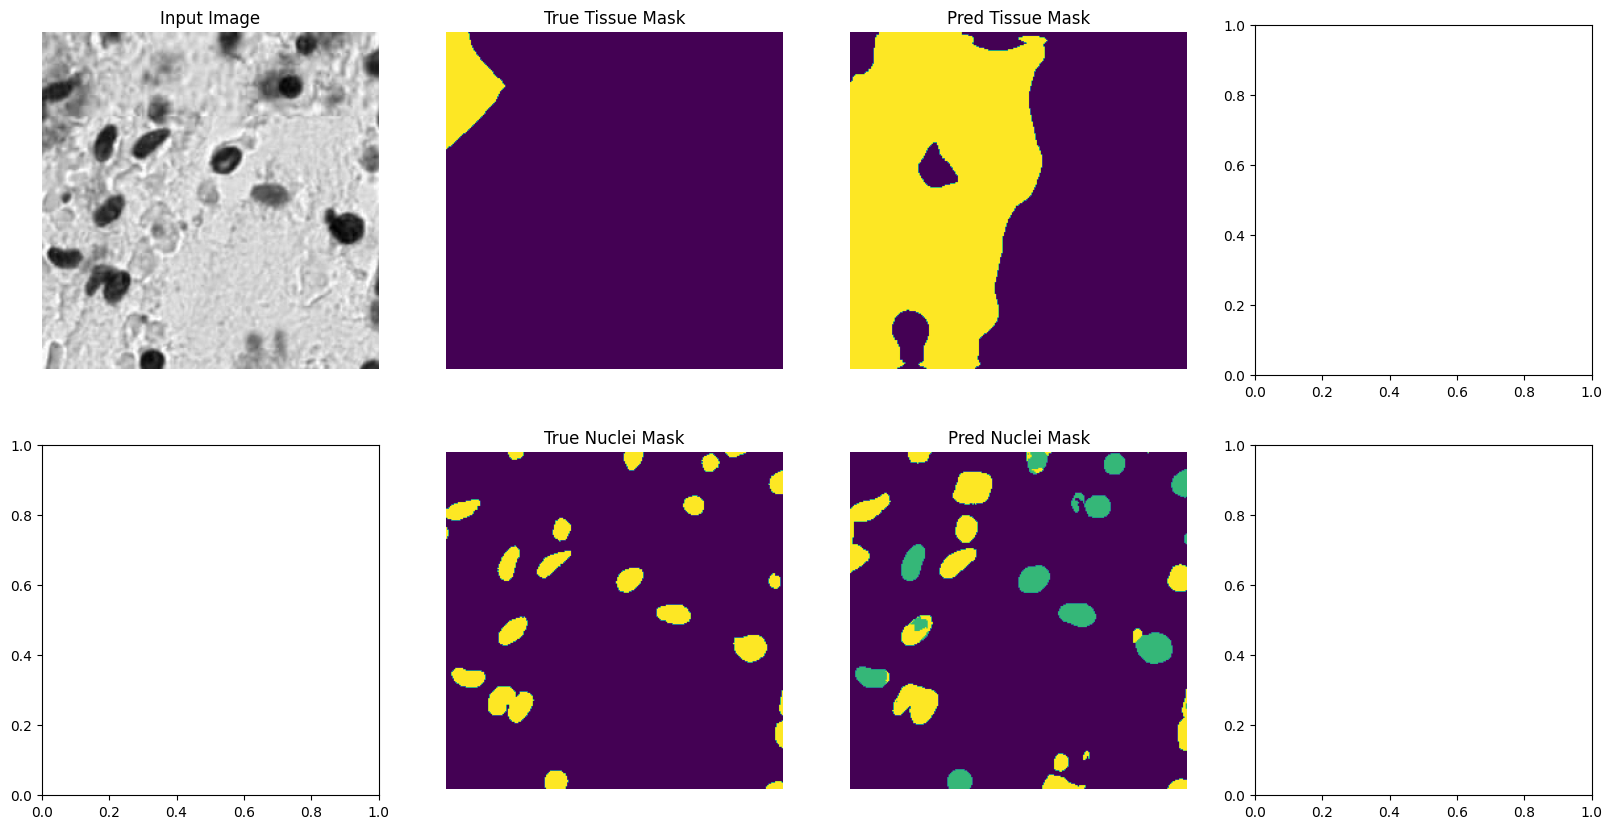

  0%|                                          | 2/1050 [00:01<09:36,  1.82it/s]

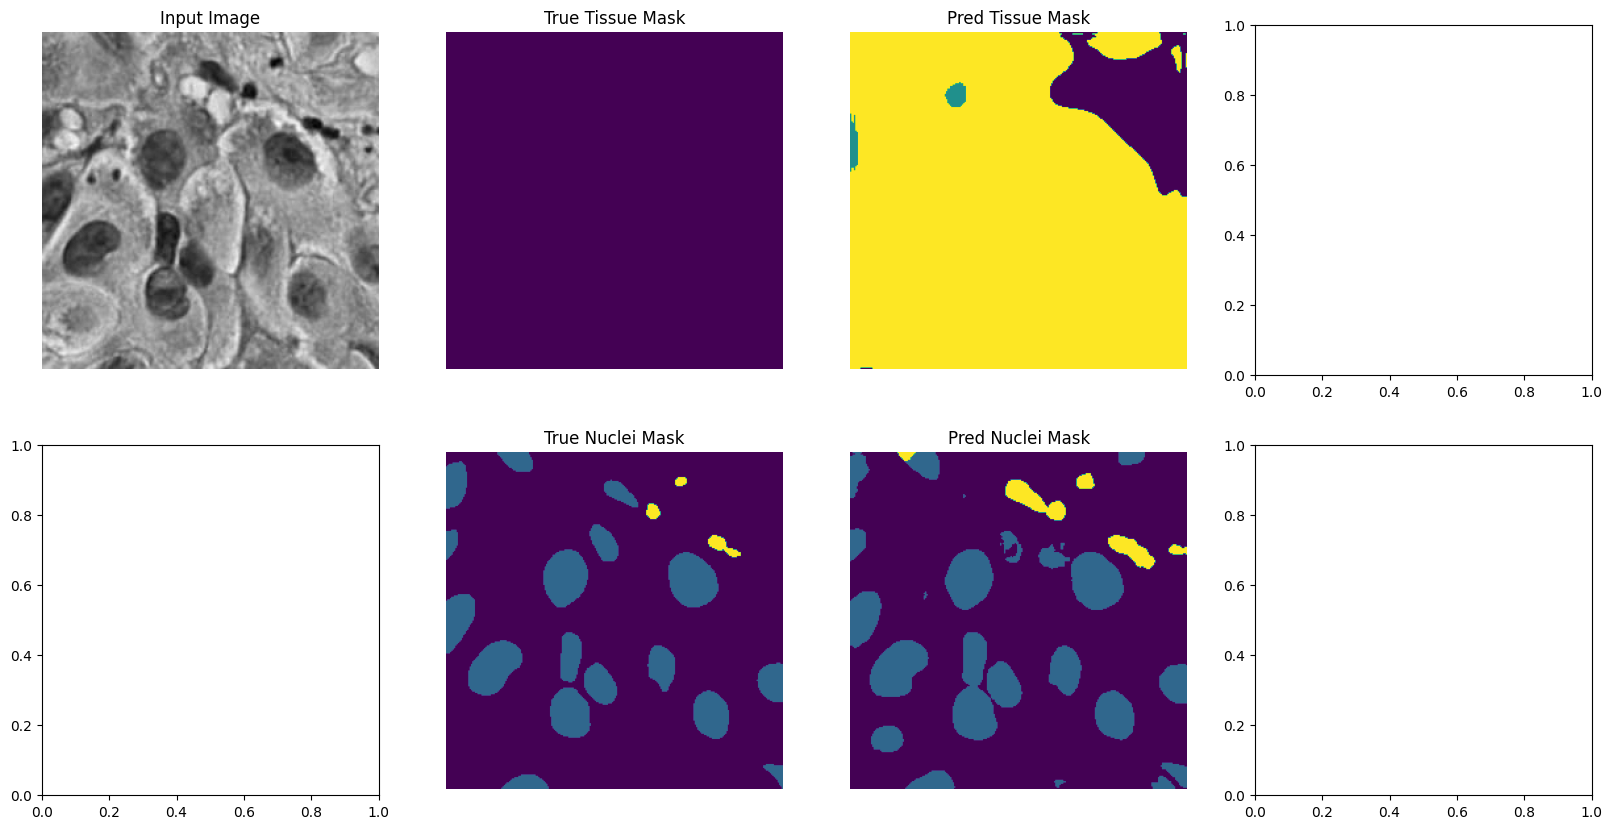

  0%|                                          | 3/1050 [00:01<11:33,  1.51it/s]


In [24]:
def visualize_samples_with_legend_and_channels(model_path, validation_data, save_path="samples"):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Class-to-color mapping for nuclei
    class_to_color_nuclei = {
        0: (255, 255, 255),  # Background
        1: (200, 0, 0),      # nuclei_tumor
        2: (255, 0, 255),    # TILs
        3: (150, 200, 150)   # Other cells
    }

    # Class-to-color mapping for tissue
    class_to_color_tissue = {
        0: (255, 255, 255),  # Background
        1: (150, 200, 150),  # tissue_stroma
        2: (0, 255, 0),      # other_tissues
        3: (200, 0, 0)       # tissue_tumor
    }

    # Model setup
    model = MultiTaskUnetPlusPlus(
        num_classes_task1_tissue=4,
        num_classes_task2_nuclei=4,
        in_channels=4,
        encoder_depth=4
    )
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    # DataLoader
    validation_loader = DataLoader(validation_data, batch_size=1, shuffle=True)

    # Generate samples
    samples_shown = 0
    for (image, t_mask, n_mask) in tqdm(validation_loader):
        if samples_shown >= 3:
            break

        # Move data to device
        image = image.to(device)

        # Model predictions
        t_output, n_output = model(image)
        t_output = torch.argmax(torch.sigmoid(t_output), dim=1).cpu().numpy()
        n_output = torch.argmax(torch.sigmoid(n_output), dim=1).cpu().numpy()

        # True masks
        t_mask = torch.argmax(t_mask, dim=3).cpu().numpy()
        n_mask = torch.argmax(n_mask, dim=3).cpu().numpy()

        # Map predictions and true masks to RGB
        t_output_rgb = map_classes_to_colors(t_output[0], class_to_color_tissue)
        n_output_rgb = map_classes_to_colors(n_output[0], class_to_color_nuclei)
        t_mask_rgb = map_classes_to_colors(t_mask[0], class_to_color_tissue)
        n_mask_rgb = map_classes_to_colors(n_mask[0], class_to_color_nuclei)

        # Plot and save
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))

        # Input image channels
        for i in range(3):  # Display first 3 channels
            axes[0, i].imshow(image[0, i].cpu(), cmap='gray')
            axes[0, i].set_title(f"Input Channel {i+1}")
            axes[0, i].axis('off')

        # Tissue masks
        axes[1, 0].imshow(image[0, 0].cpu(), cmap='gray')
        axes[1, 0].set_title("Input Image (Tissue)")
        axes[1, 0].axis('off')

        axes[1, 1].imshow(t_mask_rgb)
        axes[1, 1].set_title("True Tissue Mask")
        axes[1, 1].axis('off')

        axes[1, 2].imshow(t_output_rgb)
        axes[1, 2].set_title("Pred Tissue Mask")
        axes[1, 2].axis('off')

        # Nuclei masks
        axes[2, 0].imshow(image[0, 0].cpu(), cmap='gray')
        axes[2, 0].set_title("Input Image (Nuclei)")
        axes[2, 0].axis('off')

        axes[2, 1].imshow(n_mask_rgb)
        axes[2, 1].set_title("True Nuclei Mask")
        axes[2, 1].axis('off')

        axes[2, 2].imshow(n_output_rgb)
        axes[2, 2].set_title("Pred Nuclei Mask")
        axes[2, 2].axis('off')

        # Add legends for tissue and nuclei
        handles_tissue = [plt.Line2D([0], [0], color=np.array(color) / 255, lw=4) for color in class_to_color_tissue.values()]
        labels_tissue = ["Background", "Stroma", "Other Tissues", "Tumor"]
        axes[1, 3].legend(handles_tissue, labels_tissue, loc='center', frameon=False)
        axes[1, 3].axis('off')

        handles_nuclei = [plt.Line2D([0], [0], color=np.array(color) / 255, lw=4) for color in class_to_color_nuclei.values()]
        labels_nuclei = ["Background", "Tumor Nuclei", "TILs", "Other Cells"]
        axes[2, 3].legend(handles_nuclei, labels_nuclei, loc='center', frameon=False)
        axes[2, 3].axis('off')

        # Save figure
        plt.tight_layout()
        plt.savefig(f"logs/MTL3/sample_{samples_shown + 1}.png", dpi=150, bbox_inches="tight")
        plt.close(fig)

        samples_shown += 1


# Beispiel für die Verwendung
model_path = "logs/MTL3/best_f1.pt"
visualize_samples(model_path, validation_data, save_path="output_samples")